In [21]:
from transformers import TFAutoModel , AutoTokenizer, BertForSequenceClassification

import matplotlib.pyplot as plt
import os
import pandas as pd
import torch

from sklearn.preprocessing import LabelEncoder
import numpy as np
from torch.utils.data import TensorDataset

from torch.optim import AdamW
from torch.utils.data import DataLoader, RandomSampler

In [22]:
# Load the train and test datasets
df_train = pd.read_csv('test.csv')
df_test = pd.read_csv('train.csv')

In [23]:
df_train.head()

,text,label
0,असाध्यै राम्रो कार्यक्रम आयोजना गरिएको छ हजुरह...,1
1,"राम्रो कार्यक्रम, पहिलो सिजनले समेटेको कार्यक्...",1
2,महानायक राजेश हमाल तपाई साँच्चै धन्यवादको पात्...,1
3,जातको प्रष्न बाट सबै जनालाई सकरात्मक सन्देश मि...,1
4,"बहसको सुरुवात भएको छ, अझै जोडदार रुपमा गर्नुपर...",1


#### POSITIVE vs NEGATIVE vs NEUTRAL

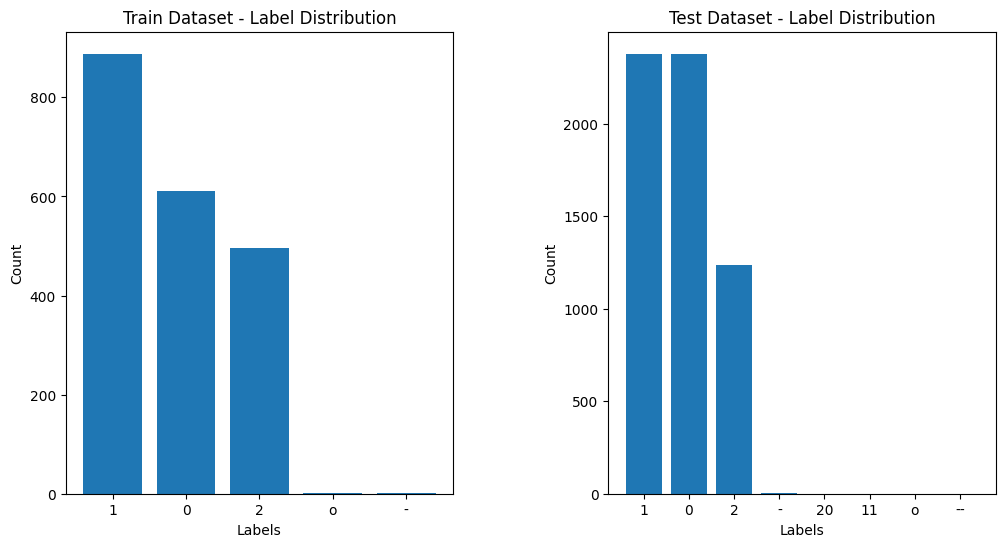

In [24]:
# Bar graph for train dataset
train_labels = df_train['label'].value_counts()

# Bar graph for test dataset
test_labels = df_test['label'].value_counts()

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Train dataset subplot
axs[0].bar(train_labels.index, train_labels.values)
axs[0].set_xlabel('Labels')
axs[0].set_ylabel('Count')
axs[0].set_title('Train Dataset - Label Distribution')

# Test dataset subplot
axs[1].bar(test_labels.index, test_labels.values)
axs[1].set_xlabel('Labels')
axs[1].set_ylabel('Count')
axs[1].set_title('Test Dataset - Label Distribution')

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.4)

# Display the plot
plt.show()


In [25]:
# Checking for missing values in the train dataset
train_na = df_train.isna().sum()
print('Train Dataset - Missing Values:')
print(train_na)

test_na = df_test.isna().sum()
print('\nTest Dataset - Missing Values:')
print(test_na)

Train Dataset - Missing Values:
text     1
label    0
dtype: int64

Test Dataset - Missing Values:
text     1
label    0
dtype: int64


In [26]:
df_train = df_train.dropna()
df_test = df_test.dropna()

# reset indexing
df_train = df_train.reset_index(drop=True)

In [27]:
# Check for missing values in the train dataset
train_na = df_train.isna().sum()
print('Train Dataset - Missing Values:')
print(train_na)

test_na = df_test.isna().sum()
print('\nTest Dataset - Missing Values:')
print(test_na)

print("Train Dataset Size:",df_train.shape )
print("Test Dataset Size:", df_test.shape)

Train Dataset - Missing Values:
text     0
label    0
dtype: int64

Test Dataset - Missing Values:
text     0
label    0
dtype: int64
Train Dataset Size: (1995, 2)
Test Dataset Size: (5999, 2)


In [28]:
# remove unwanted datas
print(df_train['label'].unique())
print(df_test['label'].unique())

valid_labels = ['0', '1', '2']


# Filter train dataset
df_train = df_train.loc[df_train['label'].isin(valid_labels)]
df_train.loc[:, 'label'] = df_train['label'].astype(int)

# Filter test dataset
df_test = df_test.loc[df_test['label'].isin(valid_labels)]
df_test.loc[:, 'label'] = df_test['label'].astype(int)


['1' '0' '2' 'o' '-']
['2' '1' '0' '20' '11' '-' 'o' '--']


In [29]:
print(df_train['label'])
print(df_test['label'])

0       1
1       1
2       1
3       1
4       1
       ..
1990    0
1991    0
1992    0
1993    0
1994    0
Name: label, Length: 1993, dtype: object
0       2
1       1
2       2
3       2
4       1
       ..
5995    1
5996    2
5997    2
5998    1
5999    1
Name: label, Length: 5990, dtype: object


In [30]:
label_encoder = LabelEncoder()

In [31]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased')

In [32]:
df_train['text'] = df_train['text'].tolist()

print(type(df_train['text']))
print(df_train['text'].head())

<class 'pandas.core.series.Series'>
0    असाध्यै राम्रो कार्यक्रम आयोजना गरिएको छ हजुरह...
1    राम्रो कार्यक्रम, पहिलो सिजनले समेटेको कार्यक्...
2    महानायक राजेश हमाल तपाई साँच्चै धन्यवादको पात्...
3    जातको प्रष्न बाट सबै जनालाई सकरात्मक सन्देश मि...
4    बहसको सुरुवात भएको छ, अझै जोडदार रुपमा गर्नुपर...
Name: text, dtype: object


In [33]:
# tokenizing training data
train_tokens = tokenizer.batch_encode_plus(
    df_train['text'].tolist(),
    padding = True,
    truncation = True,
    max_length = 512,
    return_tensors = 'pt'
)

train_labels = label_encoder.fit_transform(df_train['label'])


In [34]:
print(train_labels)

[1 1 1 ... 0 0 0]


In [35]:
# tokenizing test data
test_tokens = tokenizer.batch_encode_plus(
    df_test['text'].tolist(),
    padding=True,
    truncation=True,
    max_length=512,
    return_tensors='pt'
)

test_labels = label_encoder.fit_transform(df_test['label'])

In [36]:
print(test_labels)

[2 1 2 ... 2 1 1]


In [37]:
# Convert input sequences to tensors
train_input_ids = torch.tensor(train_tokens['input_ids'])
train_attention_masks = torch.tensor(train_tokens['attention_mask'])
train_labels = torch.tensor(df_train['label'].values.astype(np.int64)) # Convert to np.int64 before creating tensor

test_input_ids = torch.tensor(test_tokens['input_ids'])
test_attention_masks = torch.tensor(test_tokens['attention_mask'])
test_labels = torch.tensor(df_test['label'].values.astype(np.int64)) # Convert to np.int64 before creating tensor

# labels - This part might be redundant now, as labels are already converted above
# train_labels = torch.tensor(df_train['label'].values)
# test_labels = torch.tensor(df_test['label'].values)


# Create a TensorDataset
train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)

/var/folders/pn/h3qn2b790rg8mt5rsn7gsgdc0000gn/T/ipykernel_80517/1484234934.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_input_ids = torch.tensor(train_tokens['input_ids'])
/var/folders/pn/h3qn2b790rg8mt5rsn7gsgdc0000gn/T/ipykernel_80517/1484234934.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_attention_masks = torch.tensor(train_tokens['attention_mask'])
/var/folders/pn/h3qn2b790rg8mt5rsn7gsgdc0000gn/T/ipykernel_80517/1484234934.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_input_ids = torch.tensor(tes

In [38]:
type(train_dataset)

torch.utils.data.dataset.TensorDataset

In [39]:
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=3)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [40]:
# Setting device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [41]:
batch_size = 16
learning_rate = 2e-5
epochs = 10

train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
optimizer = AdamW(model.parameters(), lr=learning_rate, eps=1e-8)

In [ ]:
from tqdm import tqdm

# Setting random seed for reproducibility
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

# Training
model.train()

# Initialize lists to store loss and accuracy values
loss_values = []
accuracy_values = []

for epoch in range(epochs):
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    progress_bar = tqdm(train_dataloader, desc=f'Epoch {epoch+1}')

    for batch in progress_bar:
        batch = tuple(t.to(device) for t in batch)
        inputs = {
            'input_ids': batch[0],
            'attention_mask': batch[1],
            'labels': batch[2]
        }

        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = outputs.loss
        total_loss += loss.item()

        # Calculate accuracy
        predicted_labels = torch.argmax(outputs.logits, dim=1)
        correct_predictions += (predicted_labels == batch[2]).sum().item()
        total_predictions += batch[0].size(0)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Apply gradient clipping if necessary
        optimizer.step()

        progress_bar.set_postfix({'Training Loss': loss.item()})

    average_loss = total_loss / len(train_dataloader)
    accuracy = correct_predictions / total_predictions

    # Store loss and accuracy values
    loss_values.append(average_loss)
    accuracy_values.append(accuracy)

    print(f'Epoch {epoch+1}: Average Loss: {average_loss:.4f} - Accuracy: {accuracy:.4f}')


Epoch 1:  14%|█▍        | 18/125 [04:42<26:57, 15.11s/it, Training Loss=1.03] 

In [ ]:
epochs = range(1, epochs+1)

# Loss graph
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss_values, 'b', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Accuracy graph
plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracy_values, 'r', label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Saving the trained model
output_dir = './trained_model'
os.makedirs(output_dir, exist_ok=True)
model.save_pretrained(output_dir)

print('Training completed!')

In [ ]:
# SAVING MODEL
model.save_pretrained("my-model")

# Download
import shutil

model_directory = "my-model"

# Zip the model directory
shutil.make_archive("my-model", 'zip', model_directory)